# MS-E2121 Exercise session 9
### Problem 9.1: Uncapacitated Facility Location (UFL)

**a)**  
Let $N = \{1,\dots,n\}$ be a set of potential facilities and $M = \{1,\dots,m\}$ a set of clients. Let $y_j = 1$ if facility $j$ is opened, and $y_j = 0$ otherwise. Moreover, let $x_{ij}$ be the fraction of client $i$'s demand satisfied from facility $j$. The UFL can be formulated as the mixed-integer problem (MIP): 

$$\begin{align}
 \text{(UFL-W)} : \quad &\min_{x,y} \sum_{j\in N} f_jy_j + \sum_{i\in M}\sum_{j\in N} c_{ij}x_{ij} \\
       &\text{s.t.} \\
       &\quad \sum_{j\in N}x_{ij} = 1, &\forall i \in M,\\
       &\quad \sum_{i\in M}x_{ij} \leq my_j, &\forall  j \in N,\\
       &\quad x_{ij} \geq 0, &\forall i \in M, \forall j \in N,\\
       &\quad y_j \in \{0,1\}, &\forall j\in N,
\end{align}$$

where $f_j$ is the cost of opening facility $j$, and $c_{ij}$ is the cost of satisfying client $i$'s demand from facility $j$. Consider an instance of the UFL with opening costs $f=(4,3,4,4,7)$ and client costs

$$\begin{align*}
 (c_{ij}) = \left(
	\begin{array}{ccccc}
		12 & 13 & 6 & 0  & 1 \\
		8  & 4  & 9 & 1  & 2 \\
		2  & 6  & 6 & 0  & 1 \\
		3  & 5  & 2 & 1  & 8 \\
		8  & 0  & 5 & 10 & 8 \\
		2  & 0  & 3 & 4  & 1
	\end{array}
 \right)
\end{align*}$$

Implement (the model) and solve the problem with Julia using JuMP.

**b)**  
An alternative formulation of the UFL is of the form

$$\begin{align}
 \text{(UFL-S)} : \quad &\min_{x,y} \sum_{j\in N}f_jy_j + \sum_{i\in M}\sum_{j\in N}c_{ij}x_{ij}\\
       &\text{s.t.} \\
       &\quad \sum_{j\in N}x_{ij} = 1, &\forall i \in M,\\
       &\quad x_{ij} \leq y_j, &\forall  i\in M, \forall j \in N,\\
       &\quad x_{ij} \geq 0, &\forall i \in M, \forall j \in N,\\
       &\quad y_j \in \{0,1\}, &\forall j\in N.
\end{align}$$


Linear programming (LP) relaxations of these problems can be obtained by relaxing the binary constraints $y_j\in \{0,1\}$ to $0 \leq y_j \leq 1$ for all $j \in N$. For the same instance as in part (a), solve the LP relaxations of UFL-W and UFL-S with Julia using JuMP, and compare the optimal costs of the LP relaxations against the optimal integer cost obtained in part (a).

In [1]:
using JuMP, Cbc

Write down the problem data

In [2]:
f = [4 3 4 4 7] # Facility opening costs
c = [12 13 6 0 1; 8 4 9 1 2; 2 6 6 0 1; 3 5 2 1 8; 8 0 5 10 8; 2 0 3 4 1] # Cost of satisfying demand
(m, n) = size(c)
M = 1:m # Set of facilities
N = 1:n;# Set of clients

Implement the problem in JuMP

In [3]:
ufl_w = Model(Cbc.Optimizer)

@variable(ufl_w, x[M,N] >= 0) # Fraction of demand (client i) satisfied by facility j
@variable(ufl_w, y[N], Bin)   # Facility location

# Minimize total cost
@objective(ufl_w, Min, sum(f[j]*y[j] for j in N) + sum(c[i,j]*x[i,j] for i in M, j in N)) 

# For each client, the demand must be fulfilled
@constraint(ufl_w, demand[i in M], sum(x[i,j] for j in N) == 1)
# A big-M style constraint stating that facility j can't send out anything if y[j]==0
@constraint(ufl_w, supply[j in N], sum(x[i,j] for i in M) <= m*y[j])

optimize!(ufl_w)


Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Jan  1 1970 

command line - Cbc_C_Interface -solve -quit (default strategy 1)
Continuous objective value is 5.66667 - 0.00 seconds
Cgl0004I processed model has 11 rows, 35 columns (5 integer (5 of which binary)) and 65 elements
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.666667
Cbc0038I Pass   1: suminf.    0.00000 (0) obj. 20 iterations 5
Cbc0038I Solution found of 20
Cbc0038I Relaxing continuous gives 20
Cbc0038I Before mini branch and bound, 3 integers at bound fixed and 26 continuous
Cbc0038I Full problem 11 rows 35 columns, reduced to 1 rows 3 columns
Cbc0038I Mini branch and bound improved solution from 20 to 9 (0.01 seconds)
Cbc0038I Round again with cutoff of 8.66666
Cbc0038I Reduced cost fixing fixed 3 variables on major pass 2
Cbc0038I Pass   2: suminf.    0.25397 (1) obj. 8.66666 iterations 6
Cbc0038I Pass   3: suminf.    0.08334 (1) obj. 8.66666 iterations 4
Cbc0038I Pass   4: suminf.    0.40476 (1) o

In [4]:
println("UFL-W MILP:")
println("Optimal value $(objective_value(ufl_w))")
println("with y = $(value.(y).data)")

UFL-W MILP:
Optimal value 9.0
with y = [0.0, 1.0, 0.0, 1.0, 0.0]


In [5]:
ufl_w_rel = Model(Cbc.Optimizer)

@variable(ufl_w_rel, x[M,N] >= 0) # Fraction of demand (client i) satisfied by facility j
@variable(ufl_w_rel, 0<=y[N]<=1)  # Facility location

# Minimize total cost
@objective(ufl_w_rel, Min, sum(f[j]*y[j] for j in N) + sum(c[i,j]*x[i,j] for i in M, j in N)) 

# For each client, the demand must be fulfilled
@constraint(ufl_w_rel, demand[i in M], sum(x[i,j] for j in N) == 1)
# A big-M style constraint stating that facility j can't send out anything if y[j]==0
@constraint(ufl_w_rel, supply[j in N], sum(x[i,j] for i in M) <= m*y[j])

optimize!(ufl_w_rel)

Presolve 11 (0) rows, 35 (0) columns and 65 (0) elements
0  Obj 0 Primal inf 3.833658 (6)
8  Obj 5.6666667
Optimal - objective value 5.6666667
Optimal objective 5.666666667 - 8 iterations time 0.002


In [6]:
println("UFL-W LP:")
println("Optimal value $(objective_value(ufl_w_rel))")
println("with y = $(value.(y).data)")

UFL-W LP:
Optimal value 5.666666666666667
with y = [0.0, 0.33333333333333337, 0.0, 0.6666666666666667, 0.0]


In [7]:
ufl_s_rel = Model(Cbc.Optimizer)

@variable(ufl_s_rel, x[M,N] >= 0)
@variable(ufl_s_rel, 0<=y[N]<=1)

@objective(ufl_s_rel, Min, sum(f[j]*y[j] for j in N) + sum(c[i,j]*x[i,j] for i in M, j in N))

@constraint(ufl_s_rel, demand[i in M], sum(x[i,j] for j in N) == 1)
# The difference between the models is that UFL-S has m constraints telling that nothing can be sent to client i from facility j if y[j]==0
# In UFL-W, there is a single constraint telling that nothing can be sent from facility j if y[j]==0
@constraint(ufl_s_rel, supply[i in M, j in N], x[i,j] <= y[j])

optimize!(ufl_s_rel)

Presolve 36 (0) rows, 35 (0) columns and 90 (0) elements
0  Obj 0 Primal inf 5.9999994 (6)
11  Obj 9
Optimal - objective value 9
Optimal objective 9 - 11 iterations time 0.002


In [8]:
println("UFL-S LP:")
println("Optimal value $(objective_value(ufl_s_rel))")
println("with y = $(value.(y).data)")

UFL-S LP:
Optimal value 9.0
with y = [0.0, 1.0, 0.0, 1.0, 0.0]


#### Branching
We see that the UFL-S relaxation produces an integer solution, meaning that we have an integer optimal solution and no branching needs to be done. However, if we used UFL-W instead, we would need to do B&B or something else to obtain the integer optimum. In the UFL-W LP relaxation solution (0, 1/3, 0, 2/3, 0), we have two fractional variables $y_2$ and $y_4$, and we can branch on one of them. Let's choose $y_2$ and see what happens if we set it to 0 or 1. 

In [9]:
ufl_w_rel_y2_0 = Model(Cbc.Optimizer)

@variable(ufl_w_rel_y2_0, x[M,N] >= 0)
@variable(ufl_w_rel_y2_0, 0<=y[N]<=1)

@objective(ufl_w_rel_y2_0, Min, sum(f[j]*y[j] for j in N) + sum(c[i,j]*x[i,j] for i in M, j in N))

@constraint(ufl_w_rel_y2_0, demand[i in M], sum(x[i,j] for j in N) == 1)
@constraint(ufl_w_rel_y2_0, supply[j in N], sum(x[i,j] for i in M) <= m*y[j])
@constraint(ufl_w_rel_y2_0, y[2] == 0)

optimize!(ufl_w_rel_y2_0)

Presolve 10 (-2) rows, 28 (-7) columns and 52 (-14) elements
0  Obj 0 Primal inf 3.8336526 (6)
10  Obj 12.5
Optimal - objective value 12.5
After Postsolve, objective 12.5, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 12.5 - 10 iterations time 0.002, Presolve 0.00


In [10]:
ufl_w_rel_y2_1 = Model(Cbc.Optimizer)

@variable(ufl_w_rel_y2_1, x[M,N] >= 0)
@variable(ufl_w_rel_y2_1, 0<=y[N]<=1)

@objective(ufl_w_rel_y2_1, Min, sum(f[j]*y[j] for j in N) + sum(c[i,j]*x[i,j] for i in M, j in N))

@constraint(ufl_w_rel_y2_1, demand[i in M], sum(x[i,j] for j in N) == 1)
@constraint(ufl_w_rel_y2_1, supply[j in N], sum(x[i,j] for i in M) <= m*y[j])
@constraint(ufl_w_rel_y2_1, y[2] == 1)

optimize!(ufl_w_rel_y2_1)

Presolve 11 (-1) rows, 34 (-1) columns and 64 (-2) elements
0  Obj 3 Primal inf 4.796029 (6)
7  Obj 7.6666667
Optimal - objective value 7.6666667
After Postsolve, objective 7.6666667, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 7.666666667 - 7 iterations time 0.002, Presolve 0.00


In [11]:
println("UFL-W LP with y2=0:")
println("Optimal value $(objective_value(ufl_w_rel_y2_0))")
println("with y = $(value.(ufl_w_rel_y2_0[:y]).data)")

println()

println("UFL-W LP with y2=1:")
println("Optimal value $(objective_value(ufl_w_rel_y2_1))")
println("with y = $(value.(ufl_w_rel_y2_1[:y]).data)")

UFL-W LP with y2=0:
Optimal value 12.499999999999998
with y = [0.0, 0.0, 0.16666666666666669, 0.6666666666666667, 0.16666666666666669]

UFL-W LP with y2=1:
Optimal value 7.666666666666667
with y = [0.0, 1.0, 0.0, 0.6666666666666667, 0.0]


Both branches have fractional solutions, and more branching is thus needed. You can practice that in the next exercise.

### Problem 9.3: Solving Branch & Bound (B&B) graphically

*You can do this with pen and paper if you want to do it graphically, or solve the problems using JuMP instead if you don't feel like drawing.*

Consider the following integer programming problem $IP$:

$$\begin{matrix}
\text{max} &x_{1} &+&2x_{2} & \\
\text{s.t.}&-3x_{1} &+&4x_{2} &\le 4 \\
&3x_{1} &+&2x_{2} &\le 11 \\
&2x_{1} &-&x_{2} &\le 5 \\
&x_{1}, &x_{2} & \text{integer} &\\
\end{matrix}$$

Plot (or draw) the feasible region of the linear programming (LP) relaxation of the problem $IP$, then solve the problems using the figure. Recall that the LP relaxation of $IP$ is obtained by replacing the integrality constraints $x_1,x_2\in \mathbb{Z}_+$ by linear nonnegativity $x_1,x_2\geq 0$ and including (possible) upper bounds corresponding to the upper bounds of the integer variables ($x_1,x_2\leq 1$ for binary variables). 

(a) What is the optimal cost $z_{LP}$ of the LP relaxation of the problem $IP$? What is the optimal cost $z$ of the problem $IP$?

(b) Draw the border of the convex hull of the feasible solutions of the problem $IP$. Recall that the convex hull represents the *ideal* formulation for the problem $IP$.

(c) Solve the problem $IP$ by LP-relaxation based Branch \& Bound (B\&B). You can solve the LP relaxations at each node of the B\&B tree graphically. Start the B\&B procedure without any primal bound.

Check your solutions using JuMP. Make sure to point out the optimal solutions in the figure, as well as giving their numerical values.


In [12]:
#%
# Polyhedra is a convenient package for creating and plotting polyhedra
# (surely for other things as well, that just happens to be the only thing I've used it for)
using Polyhedra, Plots

# This function is just for this exercise here, could surely be made more general, maybe for next year's course...
function plot_sol_9_3(fs)
    # Add nonnegativity constraints and convert the intersection of halfspaces into a polyhedron p
    fs_nonnegative = fs ∩ HalfSpace([-1, 0], 0) ∩ HalfSpace([0, -1], 0)
    p = polyhedron(fs_nonnegative)
    
    # Plot the polyhedron with some opacity so that we can see the coordinate grid
    plot(p, opacity = 0.5, ratio=:equal, label="feasible region", legend = true)
    
    # Plot the objective function at four conveniently chosen values
    plot!([0, 4], [2.5, 0.5], linestyle=:dash, label="x1+2x2=5")
    plot!([0, 4], [3, 1], linestyle=:dash, label="x1+2x2=6")
    plot!([0, 4], [3.167, 1.167], linestyle=:dash, label="x1+2x2=6.33")
    plot!([0, 4], [3.5, 1.5], linestyle=:dash, label="x1+2x2=7")
    
    # Check which integer points of the original formulation remain feasible in this formulation
    integer_points = [0 0; 1 0; 2 0; 0 1; 1 1; 2 1; 3 1; 2 2] # These are the points that were originally feasible
    feasible_rows = [] # This will eventually include the row indices of feasible points in the above matrix
    for i in 1:size(integer_points)[1]
        if integer_points[i,:] in fs_nonnegative
            push!(feasible_rows, i)
        end
    end
    
    # Plot the feasible points and tweak the axes
    scatter!(integer_points[feasible_rows,1], integer_points[feasible_rows,2], label="Feasible integer points", xlim = (-0.2,4.5), ylim = (-0.2,3.5))
end;
#%

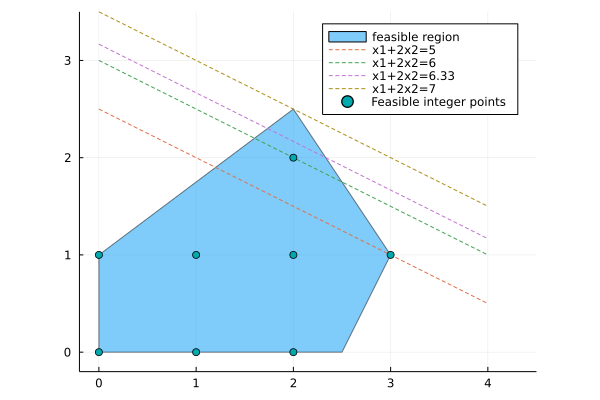

In [13]:
#%
# Plotting the feasible region using the function we wrote for this
fs_orig = HalfSpace([-3, 4], 4) ∩ HalfSpace([3, 2], 11) ∩ HalfSpace([2, -1], 5)
plot_sol_9_3(fs_orig)
#%

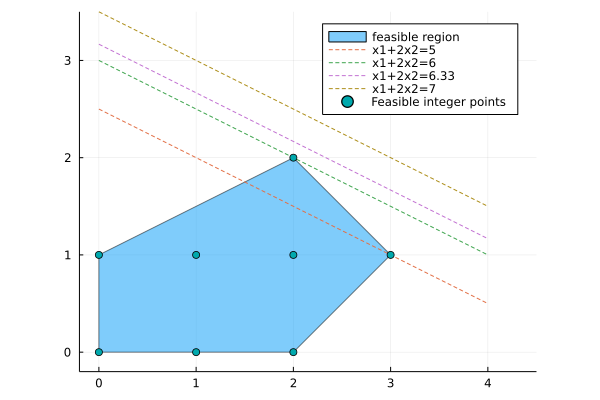

In [14]:
#%
# Convex hull obtained by adding three suitable cutting planes (more o n those next week)
fs_conv = fs_orig ∩ HalfSpace([-1, 2], 2) ∩ HalfSpace([1, 1], 4) ∩ HalfSpace([1, -1], 2) # Note that fs_conv is the intersection of the original feasible region and the three halfspaces we found
plot_sol_9_3(fs_conv)
#%

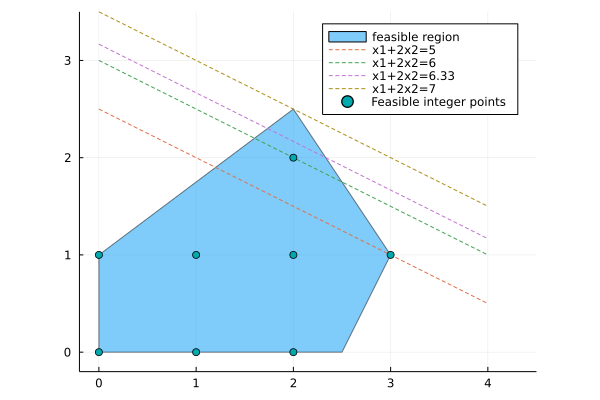

In [15]:
#%
# Plotting the original form again
plot_sol_9_3(fs_orig)
#%

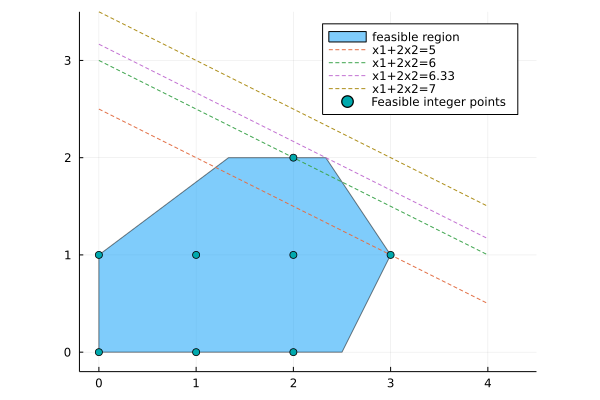

In [16]:
#%
# Branch on the fractional variable x2: constraint x2 <= 2
fs_0 = fs_orig ∩ HalfSpace([0, 1], 2)
plot_sol_9_3(fs_0)
#%

In [17]:
#%
# The solution was feasible but the solution was not integer, let's check the other branch before proceeding with this one

# Branch on the fractional variable x2: constraint x2 >= 3
fs_1 = fs_orig ∩ HalfSpace([0, -1], -3)
plot_sol_9_3(fs_1)
#%

LoadError: [91mPlotting empty polyhedron is not supported.[39m

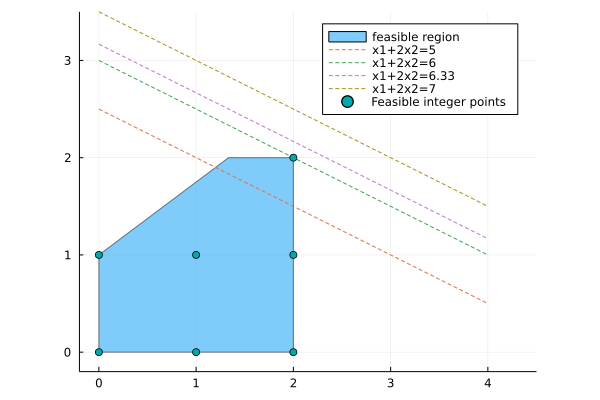

In [18]:
#%
# The other branch was infeasible and can be pruned

# Branch on the fractional variable x1: constraint x1 <= 2 (note that we also have the previous constraint x2 <= 2 in this branch)
fs_00 = fs_0 ∩ HalfSpace([1, 0], 2)
plot_sol_9_3(fs_00)
#%

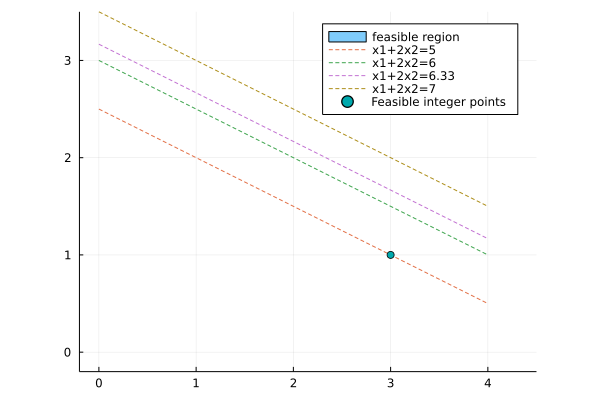

In [19]:
#%
# We found an integer solution, this means we don't need to proceed further in that direction and we only need to check the other branch  

# Branch on the fractional variable x1: constraint x1 >= 3 (note that we also have the previous constraint x2 <= 2 in this branch)
fs_01 = fs_0 ∩ HalfSpace([-1, 0], -3)
plot_sol_9_3(fs_01)
#%

In [20]:
#%
# The other branch also provided an integer point, but with a lower value than the other solution we got. 
# All branches have been searched, the best integer solution found was (2,2) with objective value 6. 
#
#                          initial solution (LP solution 7)
#                         /                         \
#           node 0 (LP solution 6.33)       node 1 (infeasible)
#         /                         \
# node 00 (integer solution 6)  node 01 (integer solution 5)
#
#%